---
title: 2D Diffusion
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

This tutorial comes from the following resources:

* 12 Steps to Navier-Stokes - 2D Diffusion -[ipynb](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/09_Step_7.ipynb)
* Practical Numerical Methods in Python - 2D Heat - [github](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/04_spreadout)
* Differential Equations in the Earth Systems - Heat 2d - [github](https://github.com/daniel-koehn/Differential-equations-earth-system/tree/master/06_Heat_2D)
* Devito CFD Tutorials - 2D Diffusion - [ipynb](https://nbviewer.org/github/devitocodes/devito/tree/master/examples/cfd/)

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= \nu\frac{\partial^2 u}{\partial x^2} + \nu\frac{\partial^2 u}{\partial y^2}
\end{aligned}
$$ (eq:2d_diffusion)

where $k$ is the diffusivity. Here, we are advised to a 2nd order accurate central difference scheme in space and 1st order temporal scheme (Euler).

## Domain

In [66]:
nx, ny = 101, 101
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 2.0

In [67]:
domain = Domain.from_numpoints(
    xmin=(xmin,ymin), 
    xmax=(xmax,ymax), N=(nx,ny))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (101, 101)
nDims: 2
Grid Size: (101, 101, 2)
Cell Volume: 0.0004


### Initial Conditions

$$
\begin{aligned}
\mathcal{IC}[u],\mathcal{IC}[v] &=
\begin{cases}
2 && \text{for }x,y \in (0.5, 1)\times(0.5,1) \\
1 && \text{everywhere else}
\end{cases}
\end{aligned}
$$

In [68]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.ones(domain.size, dtype=jnp.float64)
    u = u.at[
        int(.5 / domain.dx[0]):int(1 / domain.dx[0] + 1),
        int(.5 / domain.dx[1]):int(1 / domain.dx[1] + 1),
    ].set(2.0)
    return u

In [69]:
domain.size

(101, 101)

In [70]:
u_init = init_u0(domain)


In [71]:
grid = domain.grid

In [72]:
u_init.shape

(101, 101)

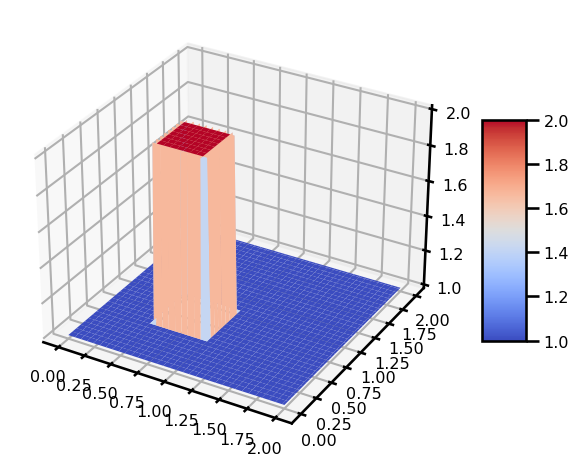

In [73]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(grid[...,0], grid[...,1], u_init, 
                       cmap=cm.coolwarm,
                       # vmin=u_init.min(), vmax=u.max()+0.1*u.max()
                      )
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

# from matplotlib import cm

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(grid[...,0], grid[...,1], u_init_smooth, 
#                        cmap=cm.coolwarm,
#                        vmin=u.min(), vmax=u.max()+0.1*u.max())
# plt.colorbar(surf, shrink=0.5, aspect=5)
# plt.tight_layout()
# plt.show()

### Boundary Conditions

$$
\begin{aligned}
\mathcal{BC}[u](\mathbf{x}) = \mathcal{BC}[v](\mathbf{x})&= 1 
&& && \mathbf{x}\in\partial\Omega
\end{aligned}
$$

In [74]:
def bc_fn(u: Array) -> Array:
    u = u.at[0,:].set(1.0)
    u = u.at[-1,:].set(1.0)
    u = u.at[:,0].set(1.0)
    u = u.at[:,-1].set(1.0)
    return u

### Equation of Motion

Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
D^-{2}_x[u] &:= \frac{\partial^2 u}{\partial x^2} \\
D^-{2}_y[u] &:= \frac{\partial^2 u}{\partial y^2} 
\end{aligned}
$$ (eq:2dnadvection)

where $D^2$ is the 2nd order accurate central difference method.

In [75]:
from typing import Optional


class Diffusion2D(DynamicalSystem):
    
    @staticmethod
    def equation_of_motion(t: float, u: Array, args):

        
        # apply boundary conditions
        u = bc_fn(u)
        
        # FD - u vector
        d2u_dx2 = fdx.difference(
            u, axis=0, step_size=(domain.dx[0]),
            accuracy=2, derivative=2, method="central"
        )
        d2u_dy2 = fdx.difference(
            u, axis=1, step_size=(domain.dx[1]),
            accuracy=2, derivative=2, method="central"
        )
        

        
        return nu * (d2u_dx2 + d2u_dy2)
    


In [76]:
#SPATIAL DISCRETIZATION
u_init = init_u0(domain)

nu = 0.05

out = Diffusion2D.equation_of_motion(0, u_init, nu)


out.min(), out.max()

(Array(-312.5, dtype=float64), Array(156.25, dtype=float64))

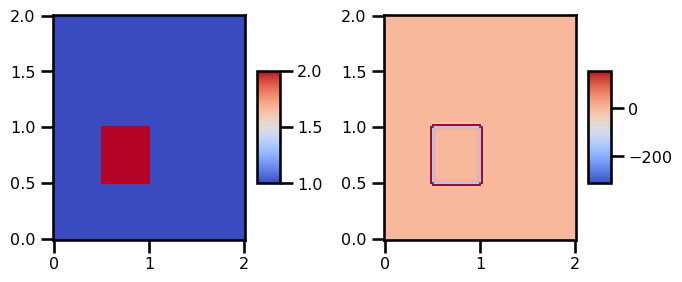

In [77]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(7,3))
surf = ax[0].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_init, 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[1].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    out, 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

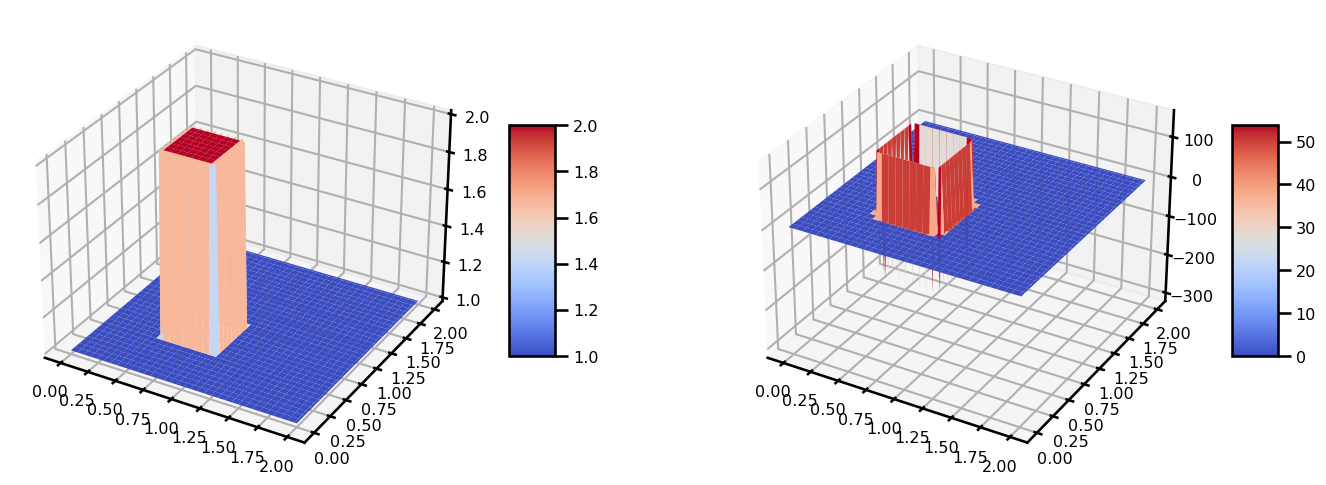

In [78]:
from matplotlib import cm

fig, ax = plt.subplots(
    ncols=2, figsize=(15,5),subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[...,0], grid[...,1], u_init, 
                       cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[...,0], grid[...,1], out, 
                       cmap=cm.coolwarm
                         )
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

## Time Stepping

In [100]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain
tmin = 0.0
tmax = 2.0
num_save = 50

#### CFD Condition

In [103]:
# temporal parameters
sigma = 0.1
nu = 0.075
dt = sigma * domain.dx[0] * domain.dx[1] / nu
print(f"Step Size (dt): {dt:.4f}")

Step Size (dt): 0.0005


In [104]:
# SPATIAL DISCRETIZATION
u_init = init_u0(domain)


t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = Diffusion2D(t_domain=t_domain, saveat=saveat)


# integration
u_sol = dyn_model.integrate(u_init, dt)

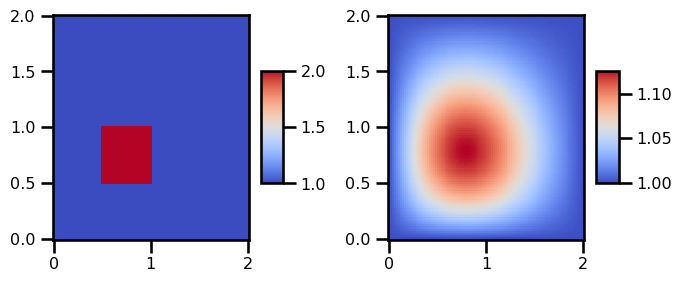

In [105]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(7,3))
surf = ax[0].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_init, 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[1].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_sol[-1], 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

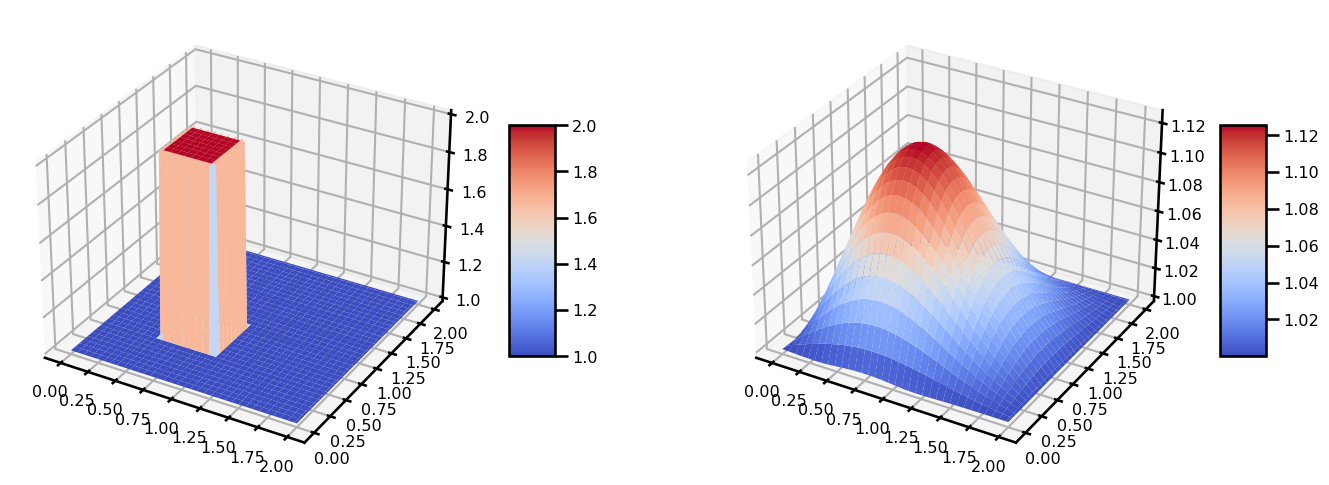

In [106]:
from matplotlib import cm

fig, ax = plt.subplots(
    ncols=2, figsize=(15,5),subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[...,0], grid[...,1], u_init, 
                       cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[...,0], grid[...,1], u_sol[-1], 
                       cmap=cm.coolwarm
                         )
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [107]:

# integration
u_more = dyn_model.integrate(u_sol[-1], dt)

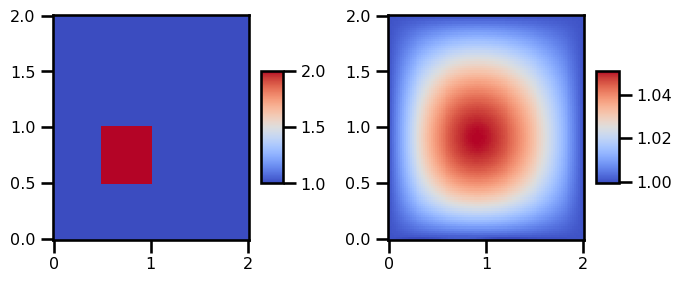

In [108]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(7,3))
surf = ax[0].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_init, 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[1].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_more[-1], 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

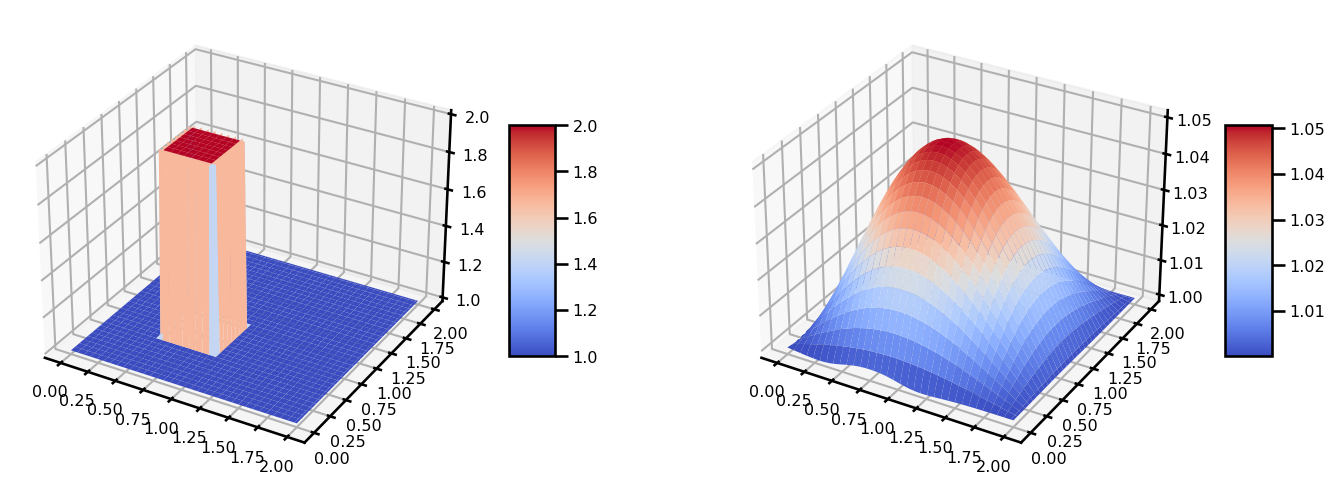

In [109]:
from matplotlib import cm

fig, ax = plt.subplots(
    ncols=2, figsize=(15,5),subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[...,0], grid[...,1], u_init, 
                       cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[...,0], grid[...,1], u_more[-1], 
                       cmap=cm.coolwarm
                         )
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [110]:

# integration
u_morre = dyn_model.integrate(u_more[-1], dt)

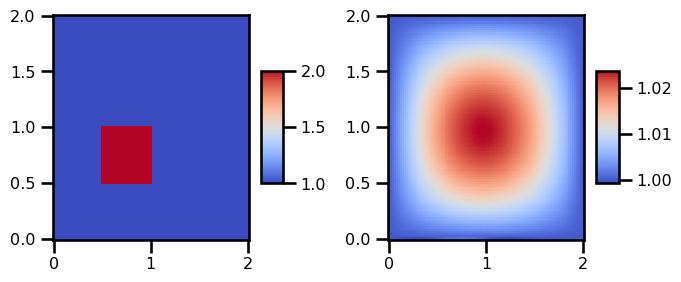

In [111]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(7,3))
surf = ax[0].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_init, 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

surf = ax[1].pcolormesh(
    domain.grid[..., 0], 
    domain.grid[..., 1],
    u_morre[-1], 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

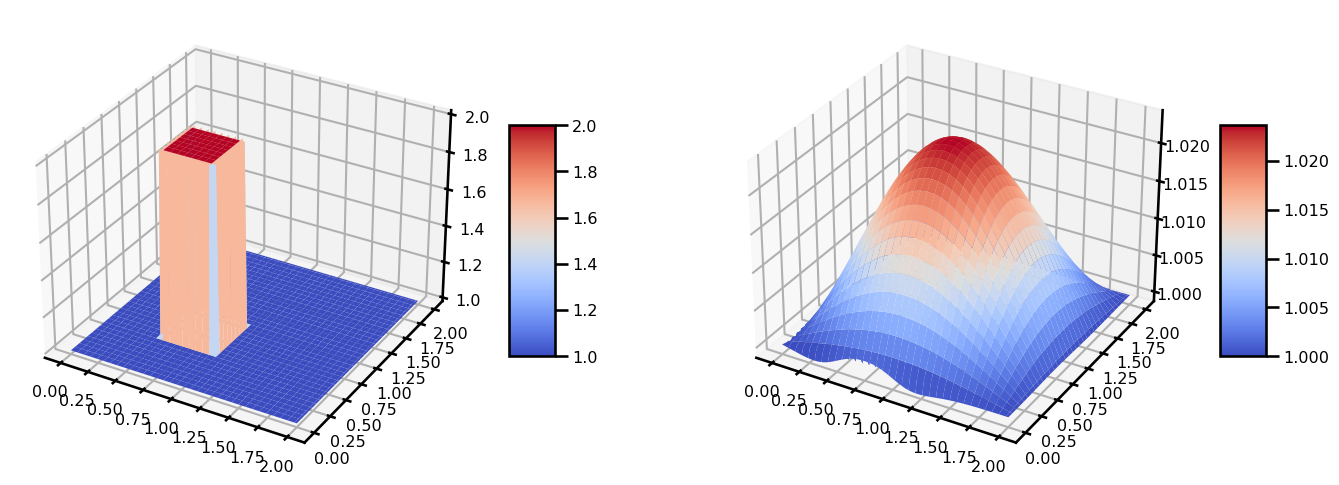

In [112]:
from matplotlib import cm

fig, ax = plt.subplots(
    ncols=2, figsize=(15,5),subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[...,0], grid[...,1], u_init, 
                       cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[...,0], grid[...,1], u_morre[-1], 
                       cmap=cm.coolwarm
                         )
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()